<a href="https://colab.research.google.com/github/ashleyteraishi/titanic-classification/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Titanic Survivors

#### Ashley Teraishi

This dataset includes information about titanic passengers and will be used to predict whether a passenger survived based on age, socio-economic class, gender, age, etc. To make these predictions I will analyze and visualize the dataset to choose the most important variables in survival. I will then use these variables in a classification tree.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Reading and preprocessing the data

_I'm including preprocessing code so you don't need to spend time on it.  There are interesting choices to be made in preprocessing this data.  One of the main concerns in the preprocessing to eliminate categorical columns that have many values.  If these columns were directly converted into numeric data using dummy variables there would be many columns added, and most of them would not be useful.  For example, the 'Cabin' column contains column numbers, and almost every value in the column is complete.  However, most cabin numbers start with one of a few capital letters, and it appears these letters may be significant._

In [2]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/titanic.csv"
df = pd.read_csv(input_file)

# column PassengerId
# a unique numeric passenger ID; not needed
df.drop('PassengerId', axis=1, inplace=True)

# column Cabin
# use only first letter of Cabin
df['Cabin'] = df['Cabin'].str.slice(stop=1)
df['Cabin'].fillna('U', inplace=True)

# column Ticket
# use two categories: tickets containing letters and
# tickets containing only digits
df['Ticket'] = df['Ticket'].str.contains('[a-zA-Z]')

# column Embarked
# hardly any NA embarked values, so drop rows containing them
df.dropna(subset=['Embarked'], inplace=True)

# column Name
# retain only the title of the name, if present
def extract_title(s):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
    for title in titles:
        if title in s:
            return title
    return 'NoTitle'

df['Title'] = df['Name'].apply(extract_title)
df.drop('Name', axis=1, inplace=True)

# column Age
# fill with median value
df['Age'].fillna(df['Age'].median(), inplace=True)

# confirm that no NA values remain
df.isna().mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    object 
 6   Ticket    889 non-null    object 
 7   Fare      889 non-null    object 
 8   Cabin     889 non-null    object 
 9   Embarked  889 non-null    object 
 10  Title     889 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 83.3+ KB


## Data exploration

_For data exploration I want you to produce at least a few interesting or relevant plots.  Use your curiousity and think about the columns that may be related to whether someone survived the sinking.  Do not include lengthy text output in your report._

### Overview of the ratio of survivors

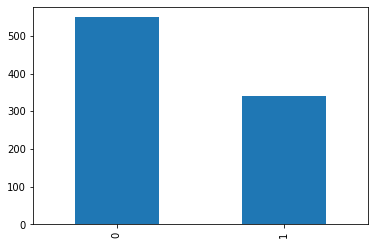

In [3]:
df['Survived'].value_counts().plot.bar()

As expected, the dataset is unbalanced with more passengers who did not survive than those who did.

### Make catergorical columns numeric using ordinal encoding (label encoding)

In [4]:
# 1st Class=0, 2nd=1, 3rd=2
df['Pclass'] = df['Pclass'].astype('category').cat.codes

# Sex values are 0 for 'female' and 1 for 'male'
df['Sex'] = df['Sex'].astype('category').cat.codes

df['Parch'] = df['Parch'].astype(int)

# Ticket values are 0 for False and 1 for True
df['Ticket'] = df['Ticket'].astype('category').cat.codes

df['Fare'].astype(float)

# A=0, B=1, C=2, D=3, E=4, F=5, G=6, T=7, U=8
df['Cabin'] = df['Cabin'].astype('category').cat.codes

# Embarked values are C=0, Q=1, S=2
df['Embarked'] = df['Embarked'].astype('category').cat.codes

# Dr.=0, Master.=1, Miss.=2, Mr.=3, Mrs.=4, NoTitle=5
df['Title'] = df['Title'].astype('category').cat.codes

### Create pairplot to get an overview of the data

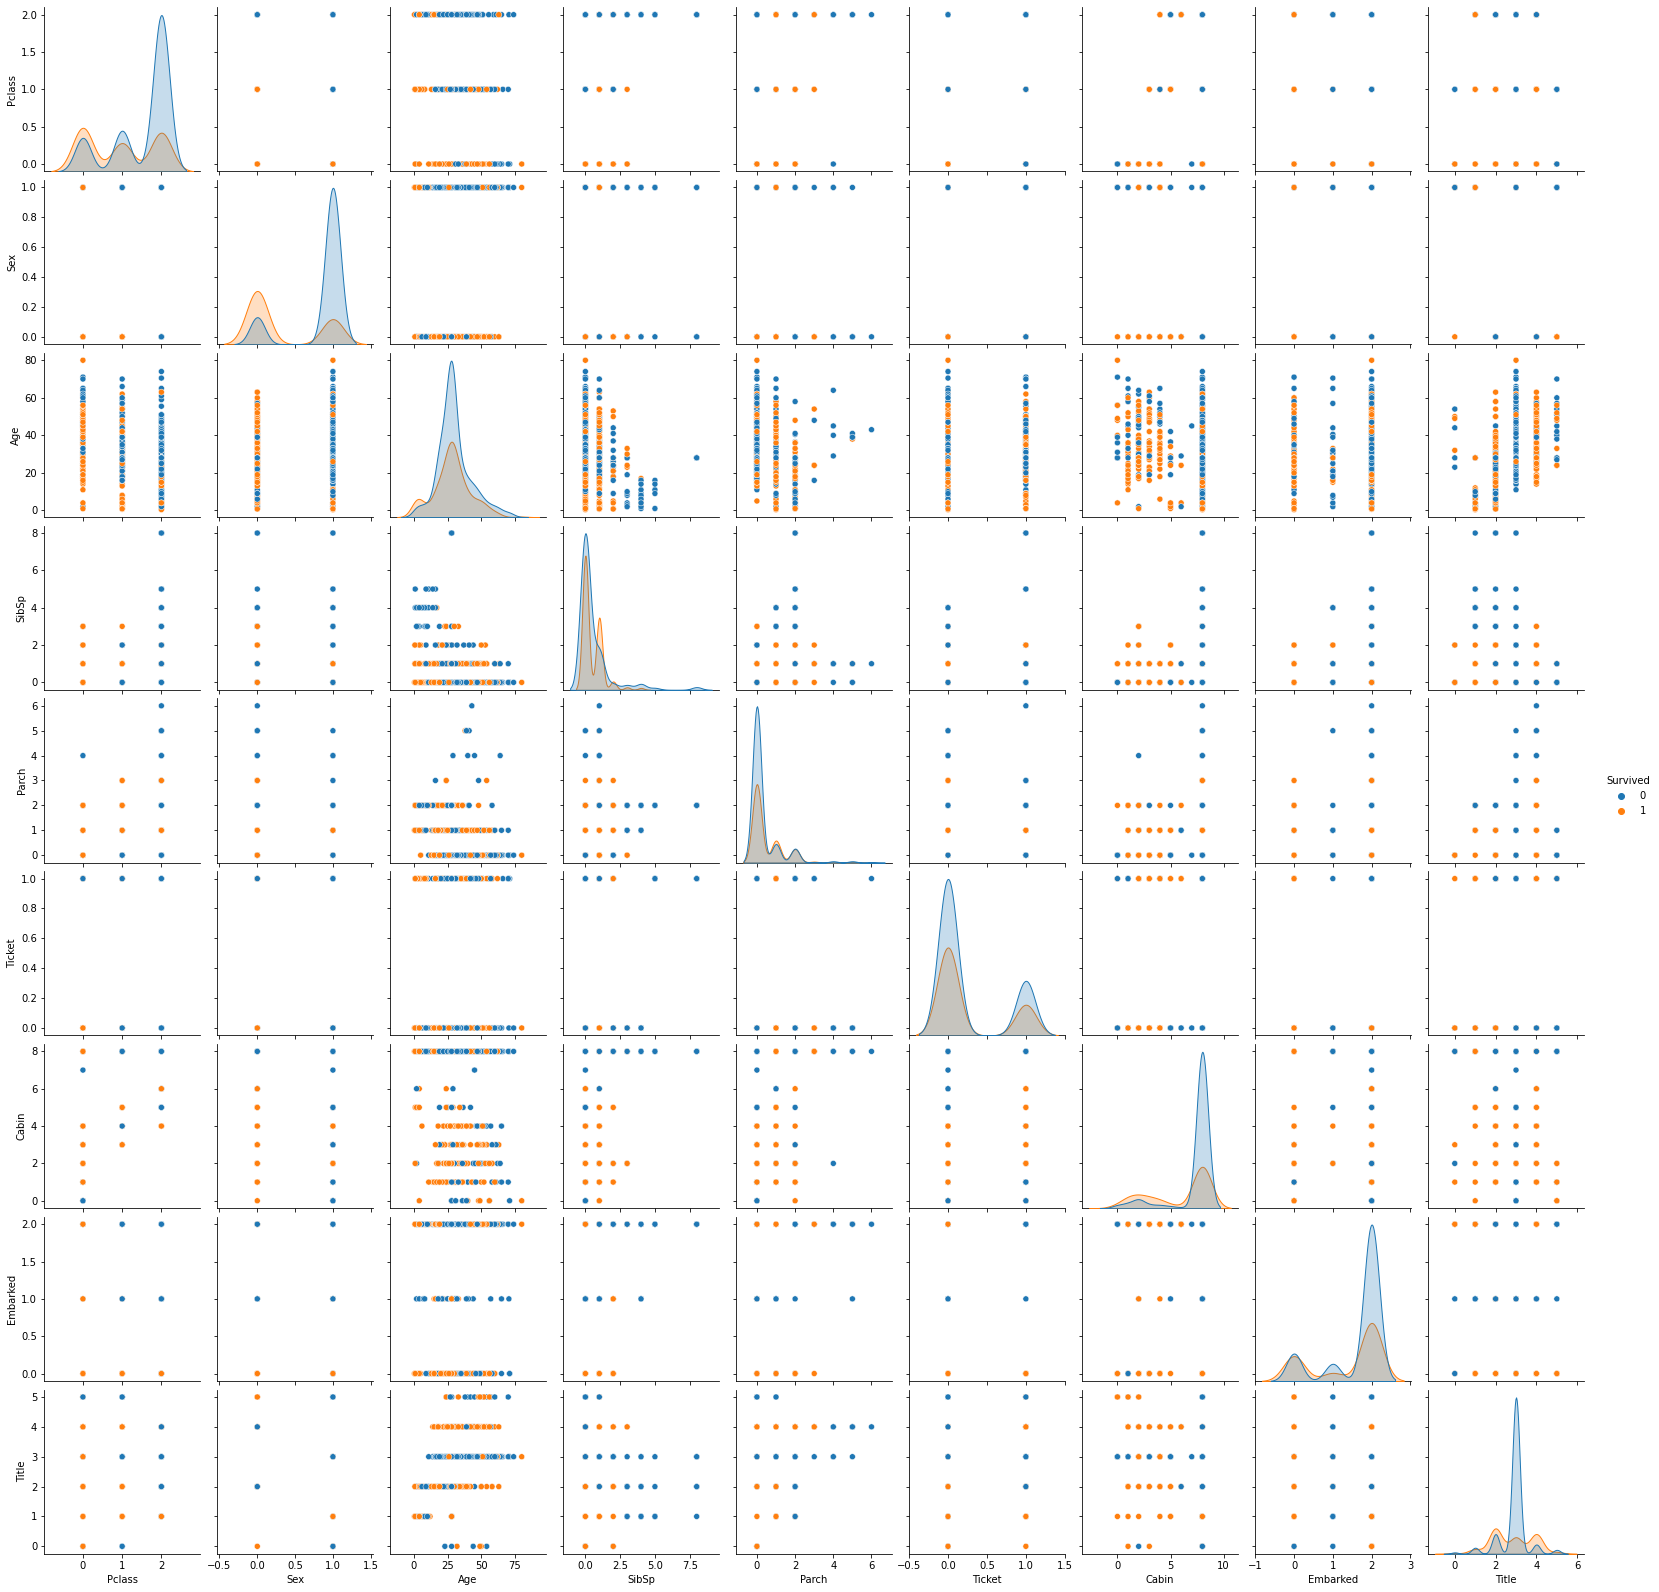

In [5]:
sns.pairplot(data=df, hue='Survived')

Some interesting associations to make note of are age and sex, age and pclass, sex and cabin, and many more. According to this initial overview, I think that age, sex, pclass, and cabin will be very important features when considering survival.

### Correlation Matrix

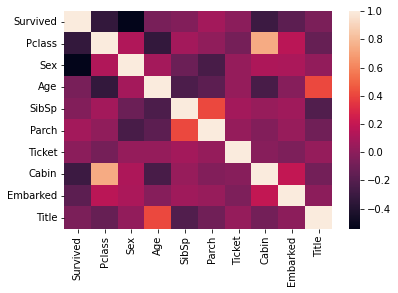

In [6]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [7]:
corr['Survived'].sort_values()

Sex        -0.541585
Pclass     -0.335549
Cabin      -0.296833
Embarked   -0.169718
Age        -0.069822
Title      -0.056345
SibSp      -0.034040
Ticket      0.000190
Parch       0.083151
Survived    1.000000
Name: Survived, dtype: float64

As expected, Sex, Pclass, and Cabin are most strongly correlated to survival.

## Building a classification tree

_In this section you should get your data ready for use with Scikit-Learn by converting categorical variables to numeric variables.  Next you should convert your data to NumPy and then split the data into training and test sets.  Build a classification tree, and produce a plot of the fitted tree._

_Remember, the job is to predict whether a passenger survives._

_Do not modify the seed below, which is included for repeatability._

In [8]:
np.random.seed(123)

### Take a look at feature importances for all columns

In [9]:
# first set X and y using all columns as predictors
X = df.drop('Survived', axis='columns')
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print('Features: ', X.columns)
print('Feature Importances: ', clf.feature_importances_)

Features:  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'Title'],
      dtype='object')
Feature Importances:  [0.09667501 0.30564446 0.22238466 0.06517319 0.00990474 0.01213064
 0.15607553 0.04352395 0.03444478 0.05404304]


According to the feature importances, our most important columns are Sex, Age, Fare, Pclass, SibSp, Title, and Cabin (in that order). Let's first try using those as our predictors.

### Grid Search to find best depth

In [10]:
# we will test max_depth values ranging from 2 to 10
params = {'max_depth':np.arange(2,11)}

# grid search using 5-fold cross validation
clf_cv = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
clf_cv.fit(X_train, y_train)

# print results
print('Best estimator:', clf_cv.best_estimator_)
print('Best accuracy:', clf_cv.best_score_)
print(clf_cv.cv_results_)

Best estimator: DecisionTreeClassifier(max_depth=6)
Best accuracy: 0.8169004601054877
{'mean_fit_time': array([0.00268688, 0.00230594, 0.00229368, 0.00246611, 0.00250111,
       0.0025898 , 0.00262556, 0.00261407, 0.0027277 ]), 'std_fit_time': array([8.34484926e-04, 7.69693165e-05, 1.66528849e-05, 8.60854976e-05,
       4.59646288e-05, 2.37159264e-05, 5.62171798e-05, 2.43935648e-05,
       1.26917660e-04]), 'mean_score_time': array([0.00137081, 0.00131135, 0.00132132, 0.00129347, 0.00128326,
       0.00132861, 0.0012816 , 0.00128655, 0.00127831]), 'std_score_time': array([9.69994613e-05, 1.48864865e-05, 9.70257582e-05, 3.72541981e-05,
       1.35623084e-05, 4.17761059e-05, 1.82552048e-05, 4.54487101e-05,
       2.01096426e-05]), 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}, {'max_depth':

As we can see above, accuracy is the best at max_depth=6

### Create Preliminary Model

In [11]:
predictors = ['Sex', 'Age', 'Fare', 'Pclass', 'SibSp', 'Title', 'Cabin']

X = df[predictors].values
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

### Display Tree

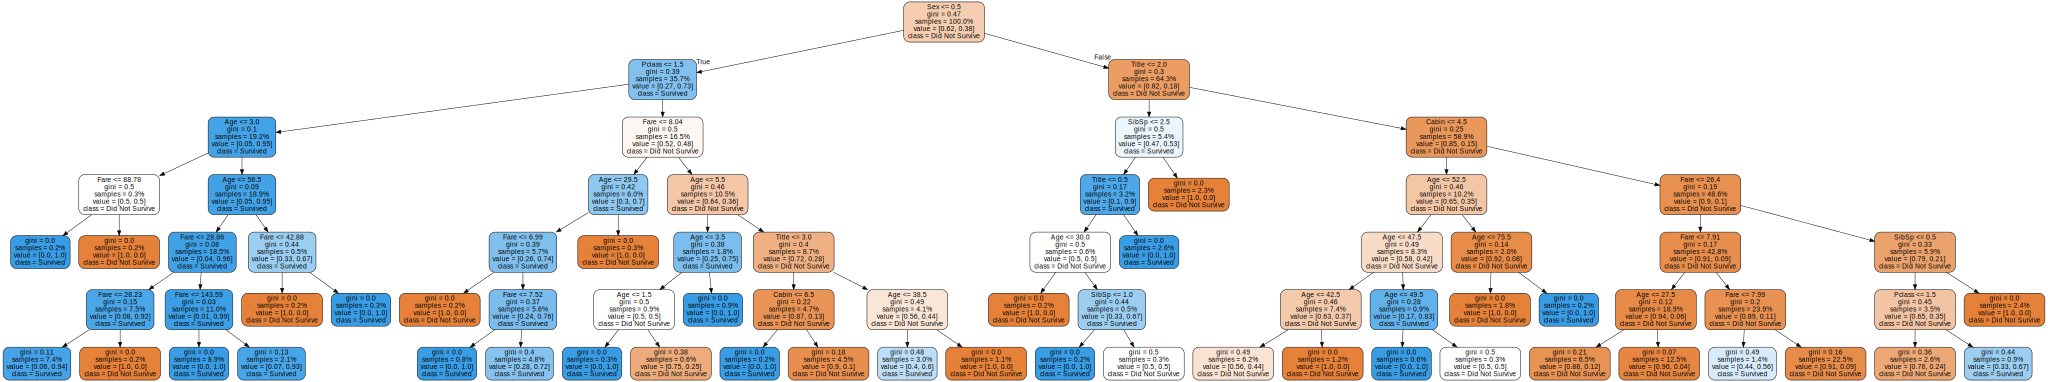

In [12]:
target_names = ['Did Not Survive', 'Survived']
dot_data = export_graphviz(clf, precision=2, feature_names=predictors, proportion=True,
                           class_names=target_names, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

## Making predictions and assessing your model

_In this section you should produce predictions from the test data. Next you will assess your results.  Minimally you will report your accuracy (success rate), and present a confusion matrix.  Don't forget to compare your accuracy to a baseline accuracy._

_Make your own choices about what other diagnostic plots to report._

_Note that DecisionTreeClassifier can be used to predict either class labels or probabilities. You can try getting probabilities, and then using some of the diagnostic plots we used with logistic regression. However, I’ve found that some of the plots used with logistic regression, such as ROC plots, don’t work well with DecisionTreeClassifier._

_I would like you to produce a learning curve to try to see if high bias or high variance is a problem. You should use this information in deciding what to do next. (See the System Design lab for code helpful in creating a learning curve.)_

Accuracy: 0.8026905829596412
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       134
           1       0.82      0.65      0.72        89

    accuracy                           0.80       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



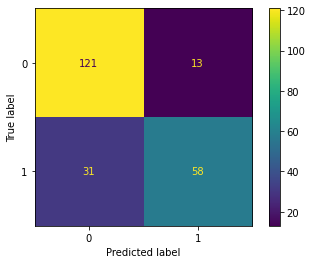

In [13]:
predictions = clf.predict(X_test)

print('Accuracy:', (predictions == y_test).mean())
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

The initial model has a decent accuracy of around 80%. 

### Learning Curve

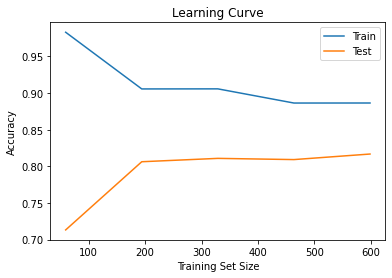

In [14]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()

## Model 2

_Based on what you learned above, you will probably want to build one or more additional models. You should assess additional models similarly to how you assessed your first one._

_Some other things you can try include: improving your model by setting the hyperparameters of the decision tree, using grid search with cross validation, and looking at feature importance._

### Forward Selection

In [15]:
# first set X and y using all columns as predictors
X = df.drop('Survived', axis='columns')
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [16]:
remaining = list(range(10))
selected = []
n = 10
while len(selected) < n:
    # find the single features that works best in conjunction
    # with the already selected features
    acc_max = 0
    i_max = 0
    for i in remaining:
      # make a version of the training data with feature i and features in selected
      feats = []
      for s in selected:
        feats.append(s)
      feats.append(i)
      x_i = X_train.iloc[:,feats]

      # compute average scores using 5-fold cross validation
      scores = cross_val_score(DecisionTreeClassifier(), x_i, y_train, scoring='accuracy', cv=5)

      # work out the average root mean squared error.  We need to
      # first negate the scores, because they are negative MSE, not MSE.
      acc = scores.mean()

      if acc > acc_max:
        acc_max = acc
        i_max = i

    remaining.remove(i_max)
    selected.append(i_max)
    print('num features: {}; accuracy: {}'.format(len(selected), acc_max))

num features: 1; accuracy: 0.7883065873639323
num features: 2; accuracy: 0.7913253282459881
num features: 3; accuracy: 0.8153405902816744
num features: 4; accuracy: 0.8168331275951072
num features: 5; accuracy: 0.8108180900011221
num features: 6; accuracy: 0.8258332398159578
num features: 7; accuracy: 0.8228369431040287
num features: 8; accuracy: 0.8138368308831782
num features: 9; accuracy: 0.8048254965772641
num features: 10; accuracy: 0.7778251599147121


Accuracy peaks at 6 features. Let's take a look at what those features are.

In [17]:
X_train.iloc[:,selected[:6]]

,Sex,SibSp,Title,Ticket,Embarked,Pclass
660,1,2,0,1,2,0
852,0,1,2,0,0,2
703,1,0,3,0,1,2
886,1,0,5,0,2,1
526,0,0,2,1,2,1
...,...,...,...,...,...,...
99,1,1,3,0,2,1
323,0,1,4,0,2,1
383,0,1,4,0,2,0
366,0,1,4,0,0,0


According to forward selection, the best features to use as predictors are Sex, SibSp, Title, Ticket, Embarked, and Pclass. 

### Decision Tree with the New Predictors

Accuracy:  0.8116591928251121
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       134
           1       0.81      0.70      0.75        89

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



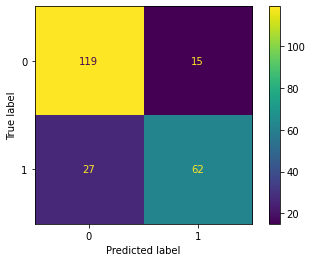

In [18]:
predictors = ['Sex', 'SibSp', 'Title', 'Ticket', 'Embarked']

X = df[predictors].values
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print('Accuracy: ', (predictions == y_test).mean())
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

### Updated Plot of Tree

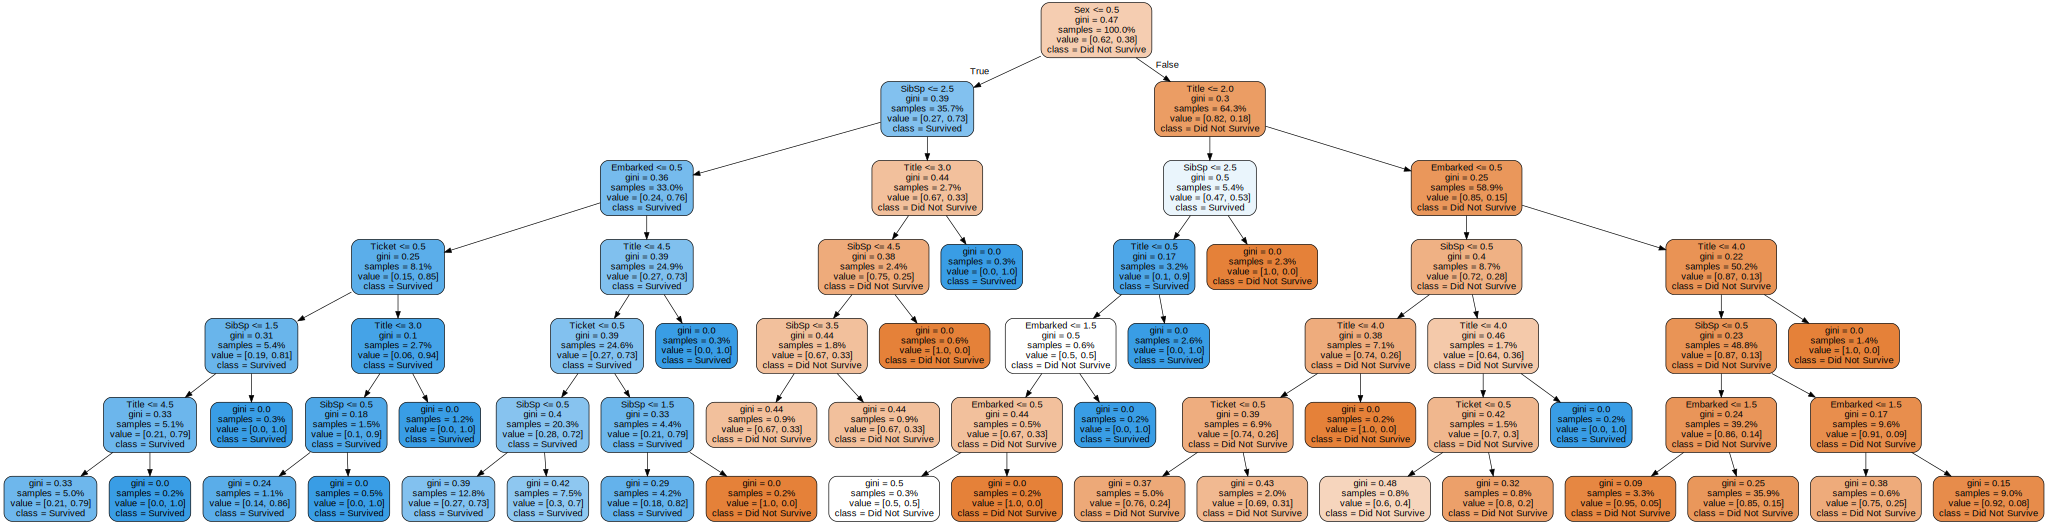

In [19]:
target_names = ['Did Not Survive', 'Survived']
dot_data = export_graphviz(clf, precision=2, feature_names=predictors, proportion=True,
                           class_names=target_names, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

### Updated Learning Curve

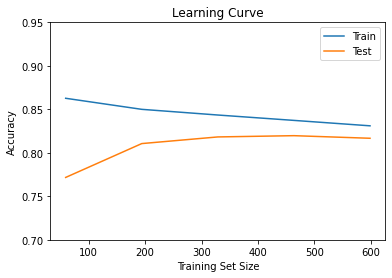

In [20]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
# use same yticks as the first learning curve for better comparison
plt.yticks([0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
plt.title('Learning Curve')
plt.legend()

## kNN Classification

Now, let's try kNN classification using the predictors that we found using forward selection.

### Initial Run using Default Parameters

Accuracy:  0.7982062780269058
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       134
           1       0.78      0.69      0.73        89

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223



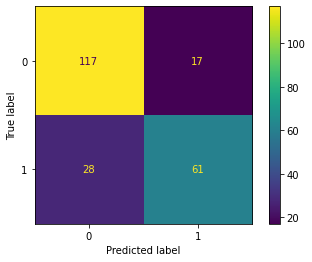

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

print('Accuracy: ', (predictions == y_test).mean())
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

### Learning Curve

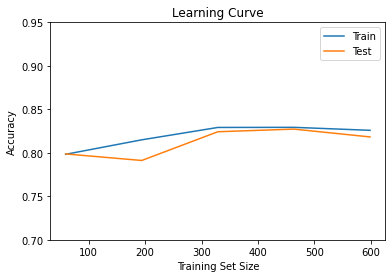

In [22]:
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
# use same yticks as the first learning curve for better comparison
plt.yticks([0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
plt.title('Learning Curve')
plt.legend()

### Grid Search to find the Best Parameters

In [23]:
params = {'n_neighbors':np.arange(2,25), 'weights':['uniform', 'distance'], 
          'algorithm':['ball_tree', 'kd_tree', 'brute'],
          'metric':['euclidean', 'manhattan', 'chebyshev']}

# grid search using 5-fold cross validation
knn_cv = GridSearchCV(KNeighborsClassifier(), params, cv=5)
knn_cv.fit(X_train, y_train)

# print results
print('Best estimator:', knn_cv.best_estimator_)
print('Best accuracy:', knn_cv.best_score_)

Best estimator: KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=19)
Best accuracy: 0.8273369992144539


### Implement kNN using Grid Search Parameters

Accuracy:  0.8071748878923767
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       134
           1       0.79      0.70      0.74        89

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.80       223



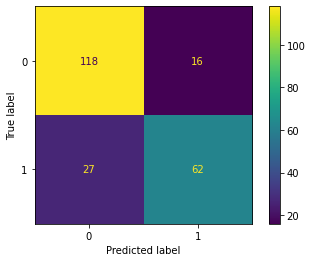

In [24]:
knn = KNeighborsClassifier(n_neighbors=19, algorithm='ball_tree', metric='manhattan')
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

print('Accuracy: ', (predictions == y_test).mean())
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

### Updated Learning Curve

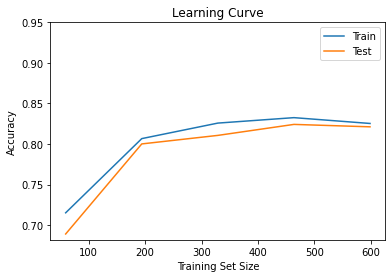

In [25]:
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
# use same yticks as the first learning curve for better comparison
plt.yticks([0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
plt.title('Learning Curve')
plt.legend()

# Random Forest Classifier

Accuracy:  0.8071748878923767
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       134
           1       0.80      0.69      0.74        89

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.79       223
weighted avg       0.81      0.81      0.80       223



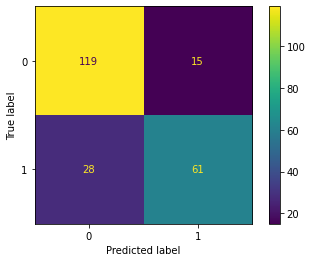

In [28]:
predictors = ['Sex', 'SibSp', 'Title', 'Ticket', 'Embarked']

X = df[predictors].values
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

clf = RandomForestClassifier(max_depth=6)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print('Accuracy: ', (predictions == y_test).mean())
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)